# Image Colorization

1. Adopt the implementation of the U-Net network from the previous task and train it on the task of image colorization.
2. Remove the skip connections of the implemented U-Net network, retrain it on the colorization task and examine the difference.

In [ ]:
import torch
import torch.nn as nn

# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         # define the neural network blocks for UNet
#         # The implementation details of the network are listed in the paper: https://arxiv.org/pdf/1505.04597.pdf
#
#     def forward(self, x):
#       # Implement the forward pass
#       pass

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNet, self).__init__()
        # define the neural network blocks for UNet
        # The implementation details of the network are listed in the paper: https://arxiv.org/pdf/1505.04597.pdf
        #num_classes = 13

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down_conv_1 = self._make_double_conv(in_channels, 64)
        self.down_conv_2 = self._make_double_conv(64, 128)
        self.down_conv_3 = self._make_double_conv(128, 256)
        self.down_conv_4 = self._make_double_conv(256, 512)
        self.down_conv_5 = self._make_double_conv(512, 1024)

        # Upsampling layers
        self.up_transpose_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv_1 = self._make_double_conv(1024, 512)
        #self.up_conv_1 = self._make_double_conv(512, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv_2 = self._make_double_conv(512, 256)
        #self.up_conv_2 = self._make_double_conv(256, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv_3 = self._make_double_conv(256, 128)
        #self.up_conv_3 = self._make_double_conv(128, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_4 = self._make_double_conv(128, 64)
        #self.up_conv_4 = self._make_double_conv(64, 64)

        # Output layer
        #self.out = nn.Conv2d(64, num_classes, kernel_size=1)
        self.out = nn.Conv2d(64, out_channels, kernel_size=1) # 3 channels for RGB

    def forward(self, x):
        down_1 = self.down_conv_1(x)
        down_2 = self.max_pool(down_1)
        down_3 = self.down_conv_2(down_2)
        down_4 = self.max_pool(down_3)
        down_5 = self.down_conv_3(down_4)
        down_6 = self.max_pool(down_5)
        down_7 = self.down_conv_4(down_6)
        down_8 = self.max_pool(down_7)
        down_9 = self.down_conv_5(down_8)

        up_1 = self.up_transpose_1(down_9)
        x = self.up_conv_1(torch.cat([down_7, up_1], 1))
        #x = self.up_conv_1(up_1)
        up_2 = self.up_transpose_2(x)
        x = self.up_conv_2(torch.cat([down_5, up_2], 1))
        #x = self.up_conv_2(up_2)
        up_3 = self.up_transpose_3(x)
        x = self.up_conv_3(torch.cat([down_3, up_3], 1))
        #x = self.up_conv_3(up_3)
        up_4 = self.up_transpose_4(x)
        x = self.up_conv_4(torch.cat([down_1, up_4], 1))
        #x = self.up_conv_4(up_4)

        x = self.out(x)
        return x

    def _make_double_conv(self, in_channels, out_channels):
        # Implement the double convolution block
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv


## Download the dataset from google drive:

In [ ]:
!pip install --upgrade --no-cache-dir gdown
#!gdown  --id 1gS35-TyG0EEcTGes-WtglcVl2Ij4WGT0
# use the other file id if the first one doesn't work
!gdown  --id 1Q0UIc27o6qlFAqNiDKfM06KwpzHCGKLU
!unzip -q landscapes.zip -d ./data

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Q0UIc27o6qlFAqNiDKfM06KwpzHCGKLU
From (redirected): https://drive.google.com/uc?id=1Q0UIc27o6qlFAqNiDKfM06KwpzHCGKLU&confirm=t&uuid=780c8388-6243-40a5-8f64-173cadfd9a69
To: /content/landscapes.zip
100% 650M/650M [00:09<00:00, 65.1MB/s]


## Colorization dataset

The dataset class loads the image and also converts them to a grayscale version. The image pair is then used for training.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import numpy as np

class ColorizationDataset(Dataset):

    def __init__(self, train=True):
        self.all_images = sorted(glob.glob("./data/*"))
        self.images = self.all_images[:-500]
        self.test_images = self.all_images[-500:]
        if not train:
          self.images = self.test_images

        self.resize_shape = (256, 256)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        gray_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        gray_image = np.array(gray_image).reshape((image.shape[0], image.shape[1], 1)).astype(np.float32) / 255.0

        image = np.transpose(image, (2, 0, 1))
        gray_image = np.transpose(gray_image, (2, 0, 1))
        return image, gray_image

    def __getitem__(self, idx):
        image, gray_image = self.transform_image(self.images[idx])
        sample = {'image': image, "gray_image": gray_image, 'idx': idx}

        return sample

## Examples of the training image pairs

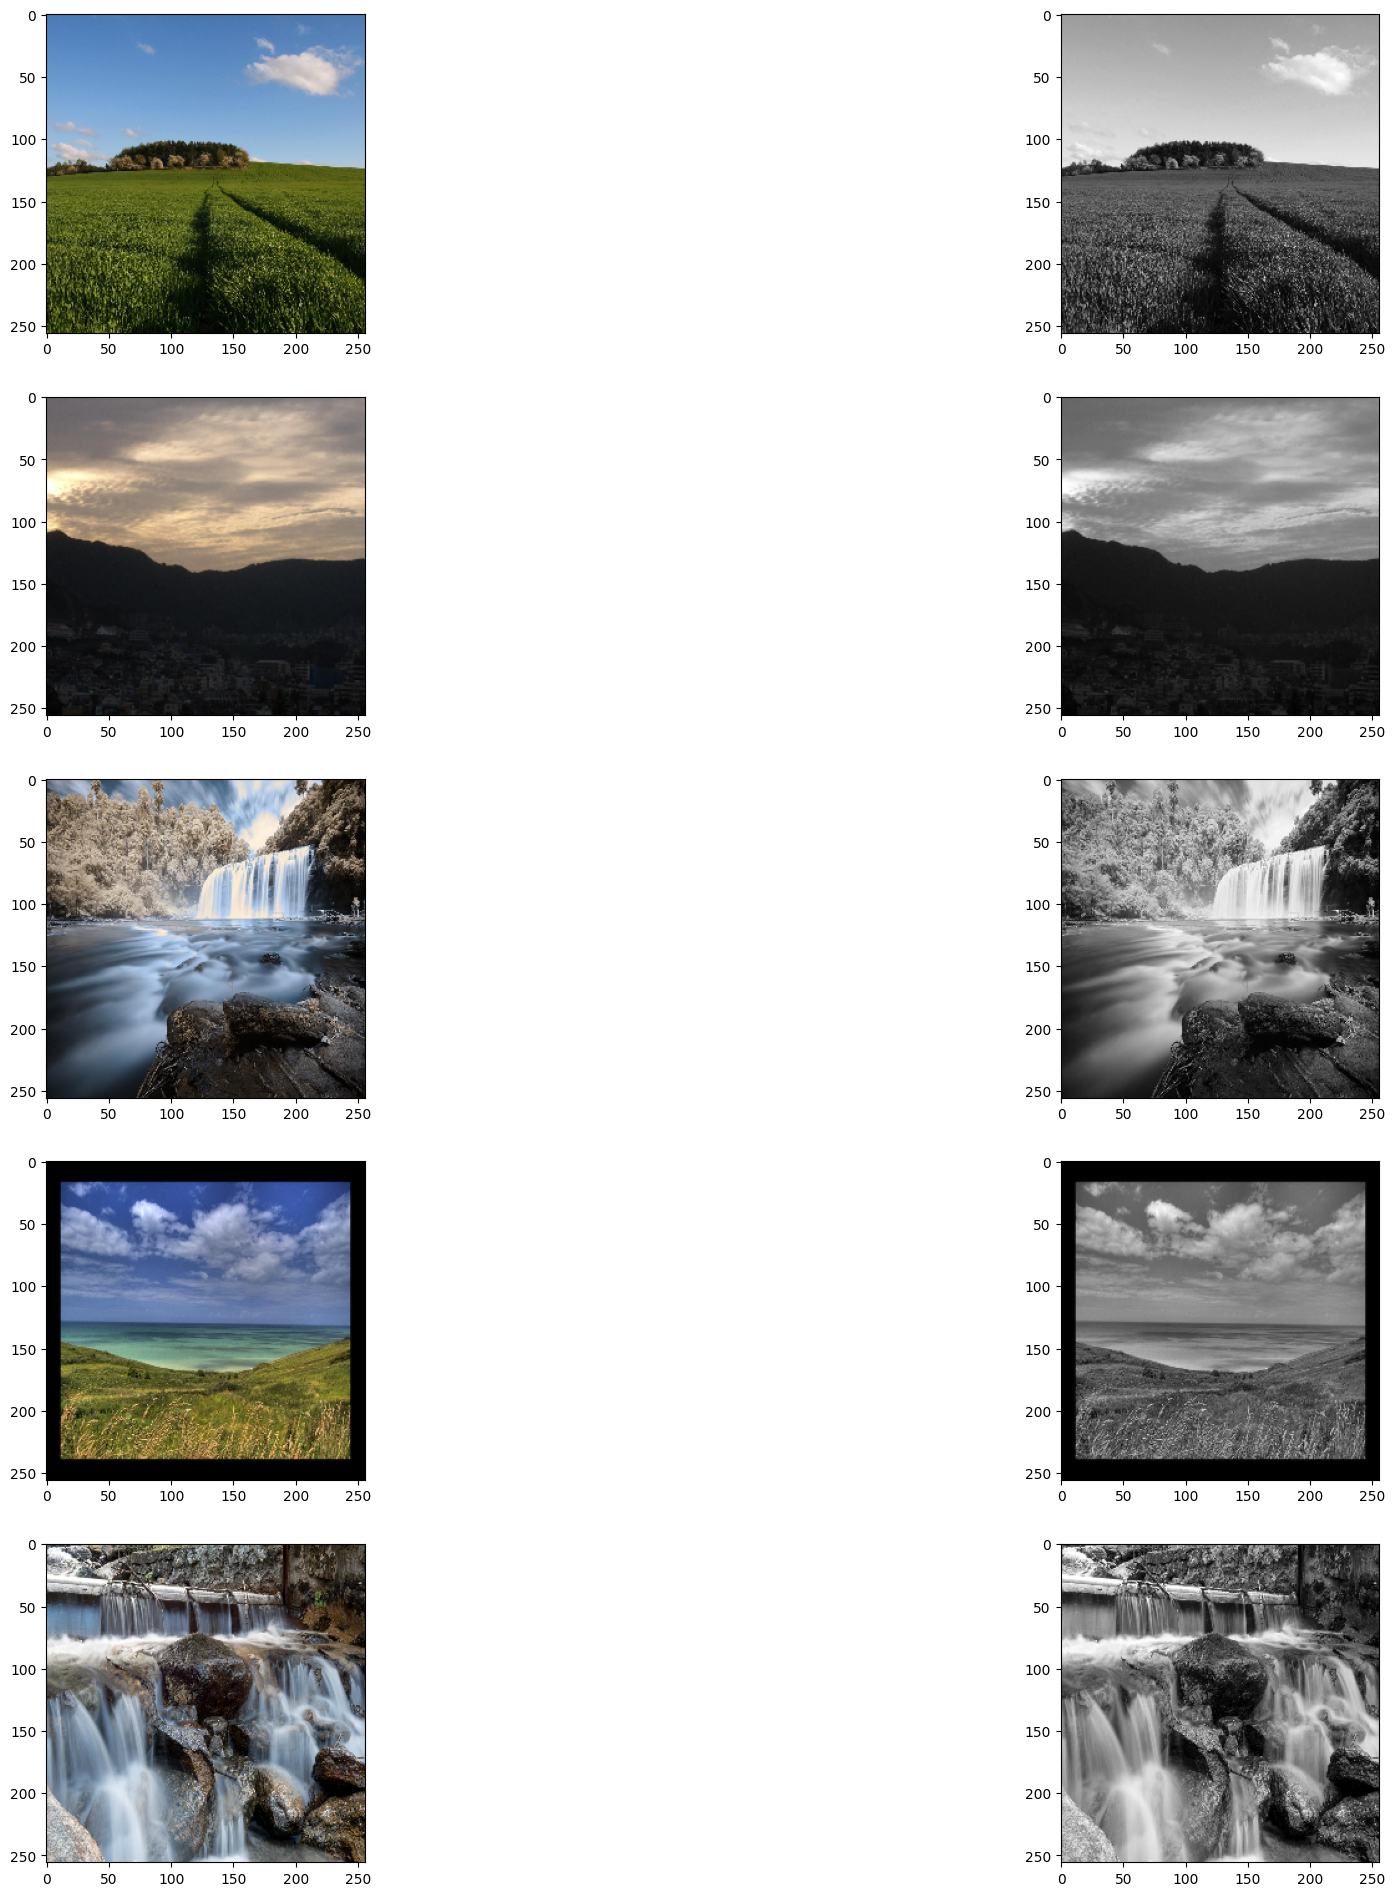

In [ ]:
import matplotlib.pyplot as plt
trainset = ColorizationDataset(train=True)
fig=plt.figure(figsize=(24, 24))
columns = 2
rows = 5
for i in range(rows):
  batch = trainset[np.random.randint(len(trainset))]
  img = batch['image'].transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = batch['gray_image'][0,:,:]
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
  fig.add_subplot(rows, columns, i*columns+2)
  plt.imshow(gray,cmap='gray')
plt.show()


## Training loop


In [ ]:
import torch
from tqdm.notebook import tqdm


trainset = ColorizationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = ColorizationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


import torch.optim as optim

net = UNet(in_channels=1, out_channels=3)
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epochs=5
#epochs = 10
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch)+"/"+str(epochs), unit='img') as prog_bar:
      for i, data in enumerate(trainloader, 0):
          # get the inputs;
          gray_images = data["gray_image"]
          color_images = data["image"]

          # Get the inputs to the GPU
          gray_images = gray_images.cuda()
          color_images = color_images.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(gray_images)
          loss = nn.functional.l1_loss(outputs, color_images)
          loss.backward()
          optimizer.step()

          prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
          prog_bar.update(4)


Epoch: 0/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 1/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 2/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 3/5:   0%|          | 0/3819 [00:00<?, ?img/s]

Epoch: 4/5:   0%|          | 0/3819 [00:00<?, ?img/s]

## Display output examples from the test set

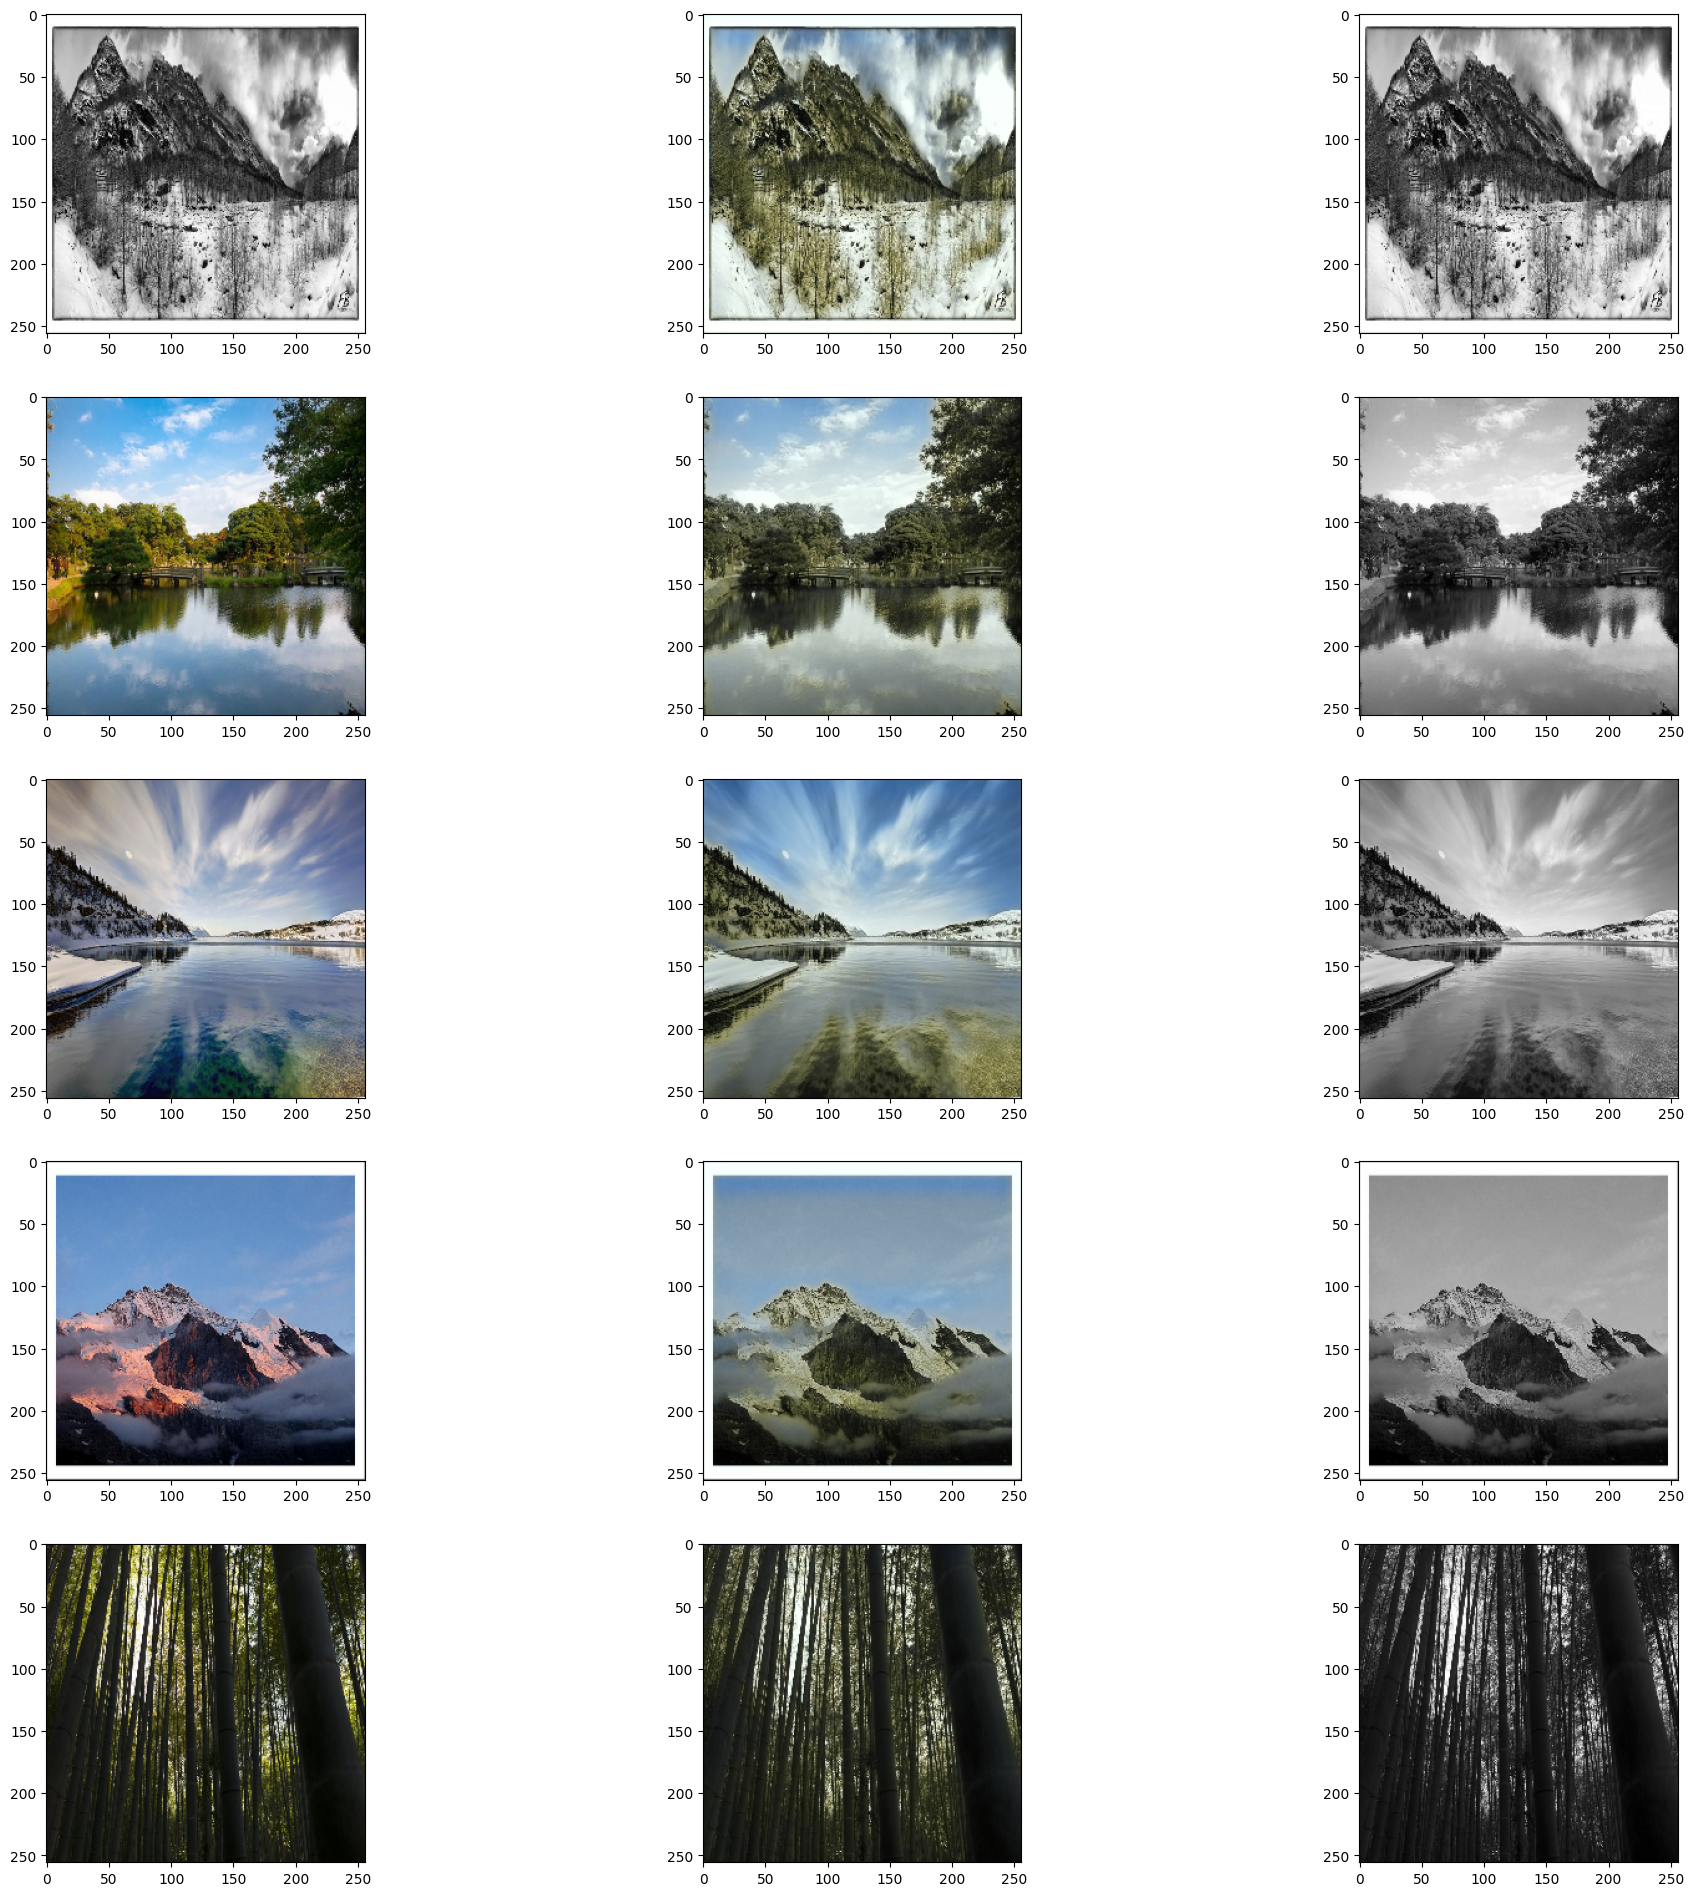

In [ ]:
net.eval()
fig=plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
  batch = testset[i+80]
  img = batch['image']
  gray = batch['gray_image']
  img_tensor = torch.from_numpy(gray).cuda()
  img_tensor = img_tensor.unsqueeze(0)
  outputs = net(img_tensor)
  out_image = outputs[0,:,:,:].detach().cpu().numpy().transpose((1,2,0))
  out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)

  img=img.transpose((1,2,0))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = gray[0,:,:]
  fig.add_subplot(rows, columns, i*columns+1)
  plt.imshow(img)
  fig.add_subplot(rows, columns, i*columns+2)
  plt.imshow(out_image)
  fig.add_subplot(rows, columns, i*columns+3)
  plt.imshow(gray,cmap='gray')

plt.show()